# AAI3001 Final Project - Preliminary Research Notebook
### Group 6
- Chua Chen Yi
- Wong Jun Kai
- Leena Soo Wei Qi
- Heng Yu Xin

#### Updated Dataset - More Failures Added (Total 630 Images)
Based on the initial testing, we have updated the dataset with 280 more images. These are obtained similarly to the initial dataset, but using two seperate cameras for another slightly different perspective. These additional images are split into (80:10:10) where 145 of 280 images have at least one failure in them. The failures simulated are also done using two different methods:

We designed [two files](https://cad.onshape.com/documents/f5fa610d41301785390c590c/w/85f44a550e1a6889dc6a74d6/e/ebb2803dda6e79d8e5a7e7c0?renderMode=0&uiState=6743750fd0d06252d2c72f97) that when printed will result in failure:

- File-1: Unsupported cantiliver. This simulates a spagehetti failure mid-print. This can occur of the print belts skip, or due to a bad design which causes the printer to print "mid-air".

- File-2: Lack of adhesion. This simulates when the print surface is dirty, and the first layer does not stick to it, similar to the initial dataset. The filament will be dragged around a large area.

#### Final Dataset - Print Bed Obstructions Added (Total 820 Images)
One area of improvement over existing models will be the use of cameras to detect if the print bed is empty before a new print job is started. Occationally, users might forget to remove previous print jobs, or might have unintentionally left small tools on the print area. In addition, newer printers will clean the nozzle before every print by "purging" them. This invovles ejecting a small ball of filament. However, occationally these will still remain stuck on the nozzle, and as a result, will fall unto the print area. Failure to check will result in errors when printing.

## Dataset Annotation
We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [1]:
# Dataset root folder
dataset_path = r"./datasets/3dprint_full"
dataset_yaml_path = "./datasets/3dprint_full.yaml"

# Images
train_folder = dataset_path + r"\images\train"
test_folder = dataset_path + r"\images\test"
val_folder = dataset_path + r"\images\val"

# Labels
train_label_folder = dataset_path + r"\labels\train"
test_label_folder = dataset_path + r"\labels\test"
val_label_folder = dataset_path + r"\labels\val"

# Project Folder
project_folder = "3dprint_yolov11m"

In [2]:
best_model_path = r"/3dprint_yolov11m/train/weights/best.pt"
LOAD_BEST_MODE = True

In [3]:
# Import Stuff
import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [4]:
# Helper function to preview bounding box. 
def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:
        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

./datasets/3dprint_full\labels\train\FC11.txt
./datasets/3dprint_full\labels\train\DP047.txt
./datasets/3dprint_full\labels\train\BA119.txt


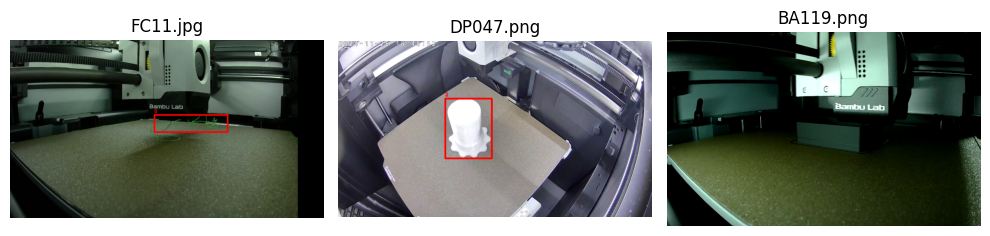

In [5]:
# Get a list of all image files in the folder
image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder
if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Train Model
#### Use transfer learning on a pre-trained YOLOv11 medium sized model, then evaluate.

In [6]:
# Import stuff
from ultralytics import YOLO

In [7]:
# Create a new YOLO model from scratch
model = YOLO("yolo11m.yaml")

In [8]:
# Train the model using the previously found hyper
results = model.train(
    data = dataset_yaml_path,
    project = project_folder,
    name = "train",
    epochs = 50,              
    batch = 16, #32 better on Kaggle, but not enough memory on my GPU
    optimizer = "Adamw",         
    lr0 = 0.001,                
    momentum = 0.937,         
    weight_decay = 0.01,   
    mosaic = 0.8,           
    fliplr = 0.5,         
    patience = 10)

New https://pypi.org/project/ultralytics/8.3.38 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
engine\trainer: task=detect, mode=train, model=yolo11m.yaml, data=./datasets/3dprint_full.yaml, epochs=50, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=3dprint_yolov11m, name=train2, exist_ok=False, pretrained=True, optimizer=Adamw, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N

train: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_full\labels\train.cache... 399 
val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_full\labels\val.cache... 40 image


Plotting labels to 3dprint_yolov11m\train2\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.01), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to 3dprint_yolov11m\train2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      8.38G      4.111      6.207      3.594          8        640: 100%|██████████| 42/42 [00:12<00:00,  3.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.59G      3.658      3.846      3.056          9        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      8.58G      3.276      3.185      2.791         16        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.355      0.102      0.108     0.0322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.58G      3.182      2.872       2.66          7        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.855      0.167      0.294      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.55G      3.015       2.59      2.548          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.886      0.218      0.302      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.58G      2.979      2.466       2.42         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.334      0.331      0.327      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.57G      2.898       2.31      2.348         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.155      0.504      0.252      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.58G      2.847      2.276      2.362          8        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.569      0.328        0.4      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.56G      2.787      2.093      2.314          8        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.683       0.14      0.145     0.0651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.59G      2.647      2.146      2.225         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.448      0.279      0.348      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.57G      2.659      1.968      2.189         15        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.486      0.425      0.436      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.58G      2.575      1.883      2.164          9        640: 100%|██████████| 42/42 [00:09<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67       0.44      0.375      0.369      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.55G      2.602       1.89      2.205         12        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.412      0.572      0.469      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.58G      2.496      1.791      2.121         15        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.452      0.532      0.502      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.57G      2.472      1.759      2.109          4        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67       0.55      0.439      0.459      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.58G      2.408      1.703       2.07         18        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.655       0.47      0.553      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.56G       2.31      1.688      2.071         14        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.457      0.432      0.468      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.56G       2.32      1.659      1.987         14        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.586      0.433      0.543      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.56G      2.253      1.574      1.968         15        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.518      0.537       0.46       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.59G      2.231      1.597      1.954         12        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67       0.64        0.5      0.537      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.57G      2.231      1.519      1.933         18        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.477      0.597       0.52      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.58G      2.178      1.502      1.894         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.627      0.521      0.556      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.57G      2.208      1.447      1.873         17        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.522      0.614       0.52      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.57G      2.142      1.473      1.939          4        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.526       0.57       0.59      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.55G      2.153      1.452      1.911          2        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.638      0.588      0.601      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.58G      2.068      1.381      1.849         13        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.738      0.518      0.588      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.59G      2.097      1.426      1.873         16        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.524      0.622      0.623      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.58G      2.079      1.348      1.782         19        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.542      0.614      0.593       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.57G      2.017      1.352      1.771          4        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.701      0.632       0.64      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.57G      1.959      1.308      1.775         15        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.684      0.685      0.667      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.54G      1.982      1.334      1.799          8        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.518       0.63      0.576       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.58G      1.961      1.274      1.716         10        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.612      0.605      0.594      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.56G      1.931      1.269      1.748          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.665      0.614       0.64      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.59G      1.927      1.244      1.745         12        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.663      0.656      0.614      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.57G      1.898      1.239       1.72          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.667      0.659      0.626      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.58G      1.847      1.196      1.656          2        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.692      0.632      0.653      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.55G      1.857      1.203      1.666         10        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.734      0.646      0.628      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.59G      1.822      1.184      1.623         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.607      0.646      0.649      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.58G      1.855      1.179      1.669          9        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.697      0.715      0.673      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.58G      1.804       1.15      1.635          4        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.626      0.716      0.638      0.358


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.55G      1.779      1.166      1.683         19        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.651      0.627      0.643      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.57G      1.797       1.13      1.658          3        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.704      0.713      0.671      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.54G      1.723      1.089      1.636          4        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.715      0.687      0.677      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.57G      1.702      1.063      1.616          6        640: 100%|██████████| 42/42 [00:09<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.637      0.664      0.641      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.55G      1.708      1.067      1.632         14        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.662      0.776      0.714      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.58G      1.689      1.063      1.601          6        640: 100%|██████████| 42/42 [00:09<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.628      0.737      0.677      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.56G      1.669      1.037      1.591         11        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.623      0.684      0.665       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.57G      1.636      1.024      1.621          6        640: 100%|██████████| 42/42 [00:09<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67        0.6      0.747      0.677      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.56G      1.654      1.029      1.561          7        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.607      0.754      0.687      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.58G      1.619      0.998      1.572          6        640: 100%|██████████| 42/42 [00:10<00:00,  4.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0

                   all         74         67      0.629      0.777      0.699      0.402



50 epochs completed in 0.166 hours.
Optimizer stripped from 3dprint_yolov11m\train2\weights\last.pt, 40.5MB
Optimizer stripped from 3dprint_yolov11m\train2\weights\best.pt, 40.5MB

Validating 3dprint_yolov11m\train2\weights\best.pt...
WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)
YOLO11m summary (fused): 303 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<0


                   all         74         67      0.623       0.77      0.699      0.402
               failure         27         38      0.584      0.701      0.683      0.249
                 purge          4         19      0.344      0.608      0.418      0.136
                 print          9         10       0.94          1      0.995      0.821
Speed: 0.6ms preprocess, 4.3ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to 3dprint_yolov11m\train2


In [12]:
# Evaluate the model's performance on the test set
results = model.val(data=dataset_yaml_path, project=project_folder, name='test', split='test')

WARNING  validating an untrained model YAML will result in 0 mAP.
Ultralytics 8.3.36  Python-3.11.9 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3080, 10240MiB)


val: Scanning C:\Users\ChenYi\Documents\Github\AAI3001-Final-Project\datasets\3dprint_full\labels\test.cache... 45 imag
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<0


                   all         84         70      0.728      0.769      0.767      0.419
               failure         33         48      0.714      0.708      0.757      0.311
                 purge          1          5      0.518        0.6      0.548      0.125
                 print         11         17      0.952          1      0.995      0.823
Speed: 0.5ms preprocess, 8.4ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to 3dprint_yolov11m\test3


# View Results

In [15]:
# Load the generated images
batch_number = 3
image1 = project_folder + f"/test{batch_number}/val_batch0_labels.jpg"
image2 = project_folder + f"/test{batch_number}/val_batch0_pred.jpg"
image3 = project_folder + f"/test{batch_number}/val_batch1_labels.jpg"
image4 = project_folder + f"/test{batch_number}/val_batch1_pred.jpg"

Previewing results from project: '3dprint_yolov11m'

[LABEL] image: 3dprint_yolov11m/test3/val_batch0_labels.jpg ------------------------------------



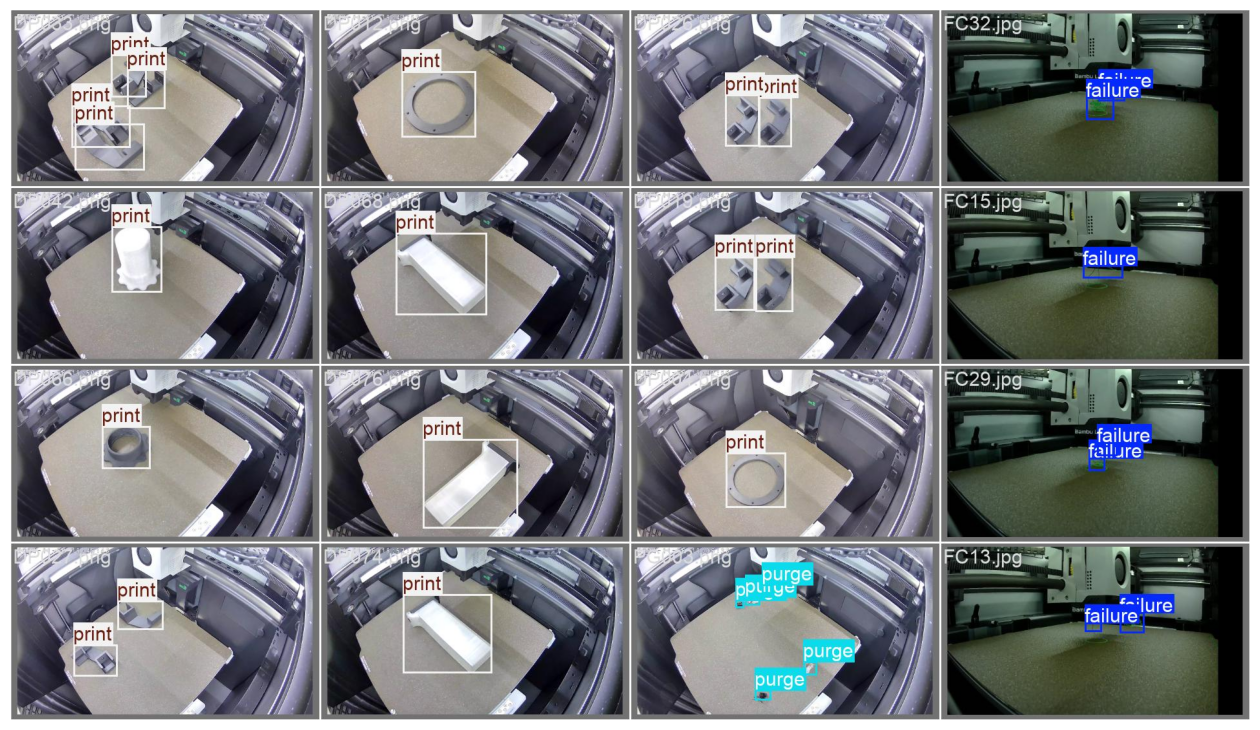



[PREDICTION] image: 3dprint_yolov11m/test3/val_batch0_pred.jpg ------------------------------------



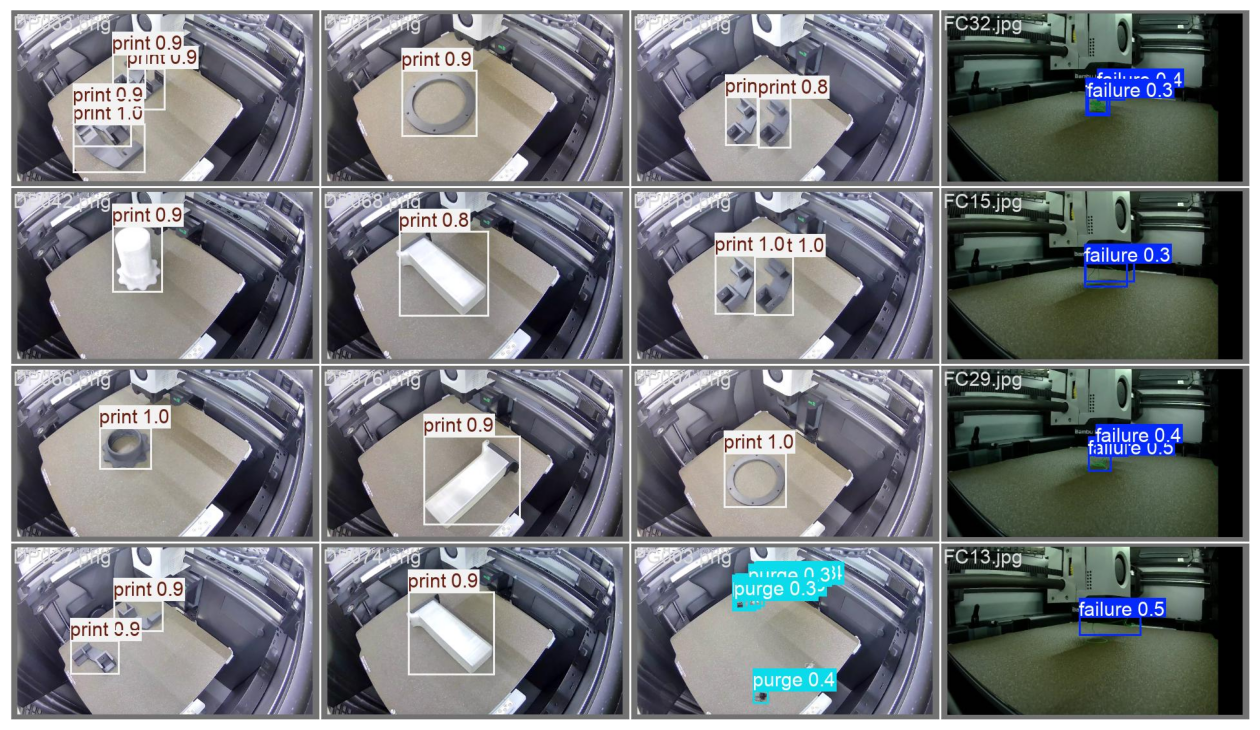



[LABEL] image: 3dprint_yolov11m/test3/val_batch1_labels.jpg ------------------------------------



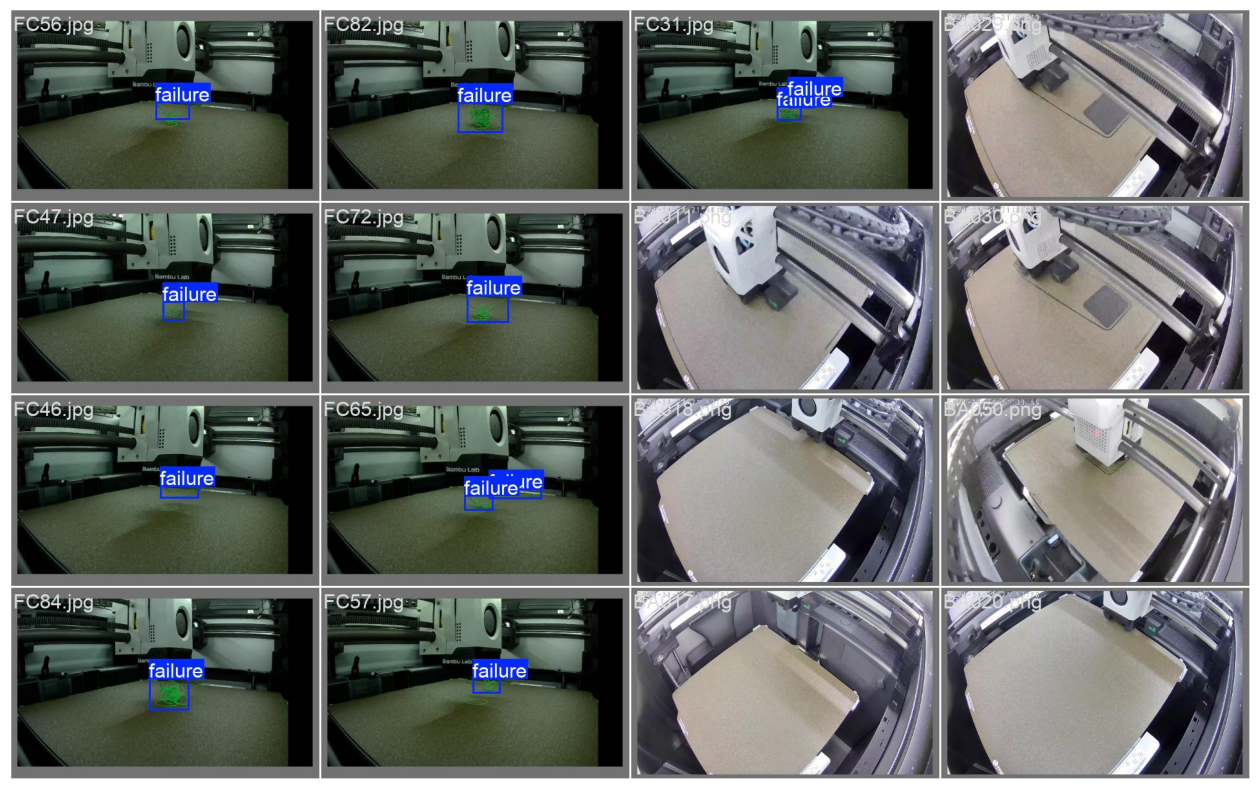



[PREDICTION] image: 3dprint_yolov11m/test3/val_batch1_pred.jpg ------------------------------------



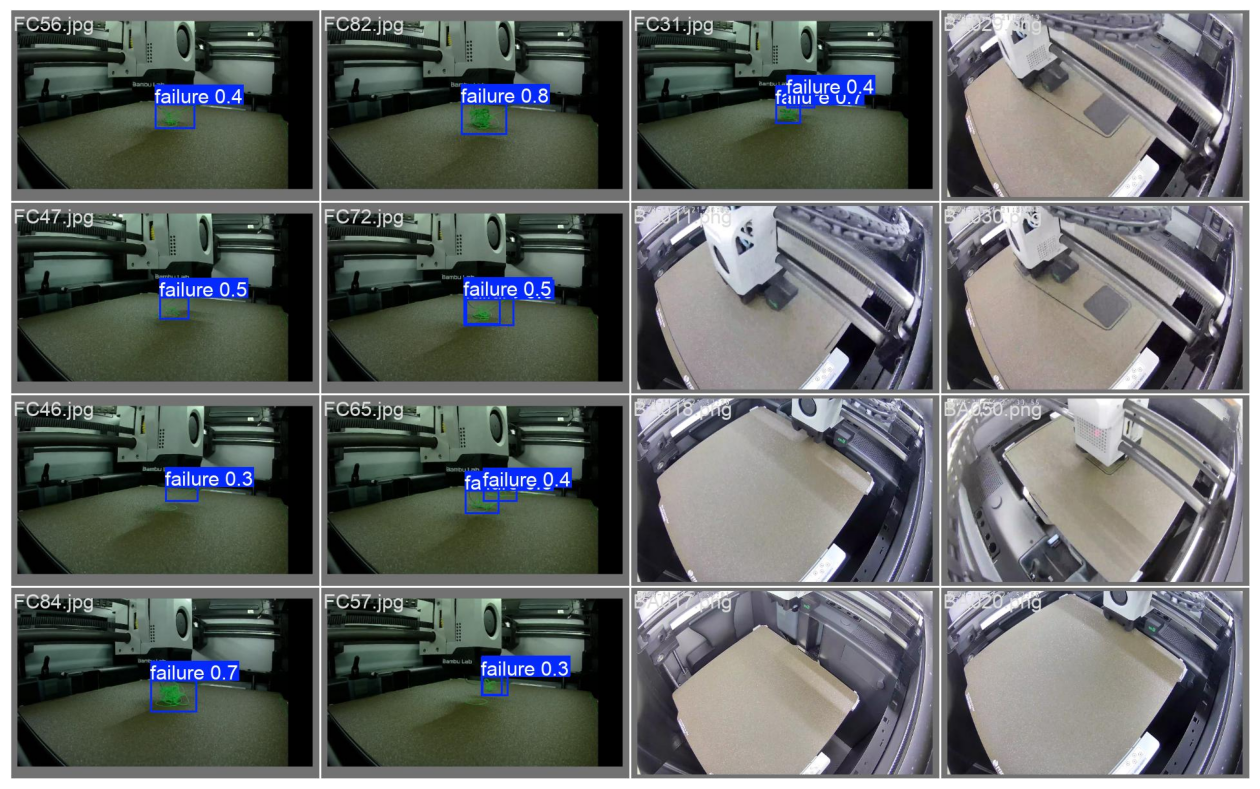

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(f"Previewing results from project: '{project_folder}'\n")

# Load the image
count = 1
for path in [image1, image2, image3, image4]:
        
    if ((count % 2) == 0):
        print(f"[PREDICTION] image: {path} ------------------------------------\n")
    else:
        print(f"[LABEL] image: {path} ------------------------------------\n")
    count += 1;
    
    img = mpimg.imread(path)
    plt.figure(figsize=(16, 16))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    print("\n")

# Evaluation
#### *On initial dataset of 350 images!*
- Overall it performed unexpectedly well based on the generated images. Except for FC46.jpg where it was unable to detect the very small loose filament oozing from the nozzle.
- It was able to correctly identify at least one failure from each of the images with failures. 
- Crucially, none of the background images have any false positives. This is important, as it means it has a low false positive rate, or high precision. In most AI fault detection systems, a false positive will cause the print to stop until a human gives it the clearance to proceed if it was a false positive, wasting time.**